In [84]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

First we import the data from the test simulations

In [85]:
simDataTable=pd.read_csv("Test_Simulation_Milestoning_Data.csv")
simDataTable.head()

,Window,Frame,Time,X,V,F,E
0,0,4999,4.999,-4.247538,-0.969001,0.132736,1.619168
1,0,9999,9.999,-3.482628,1.058192,-0.064889,1.639758
2,0,14999,14.999,-4.703842,-0.638915,2.185418,1.348027
3,0,19999,19.999,-3.155821,-0.057287,-3.343171,0.908789
4,0,24999,24.999,-4.673044,0.711303,1.876469,1.411388


Now we need to bin the coordinate data.
For this we need to know the window bounds

In [86]:
windowWidth=1.0
windowK=10.0
windowCenters=np.arange(-4,5)*windowWidth
winMaxs=windowCenters+windowWidth/2.0
winMins=windowCenters-windowWidth/2.0

For the one dimensional case, assingin bin indices can be easily accomplished by the numpy command 'digitize'

The example below illustartes this.

Note that we need two additional 'bins'.
Bin zero will account for anything to the left of the leftmost window edge and the last bin will capture anything to the right of the rightmost window edge.

We then use didgitize to apply this bin indexing to an array of numbers from -5 to 5 spaced .25 units apart.

In [87]:
xvals=np.arange(-20,21)*.25
print zip(np.arange(len(windowCenters))+1,zip(winMins,winMaxs))
print zip(xvals,np.digitize(xvals,bins=np.concatenate([winMins,[winMaxs[-1]]])))

[(1, (-4.5, -3.5)), (2, (-3.5, -2.5)), (3, (-2.5, -1.5)), (4, (-1.5, -0.5)), (5, (-0.5, 0.5)), (6, (0.5, 1.5)), (7, (1.5, 2.5)), (8, (2.5, 3.5)), (9, (3.5, 4.5))]
[(-5.0, 0), (-4.75, 0), (-4.5, 1), (-4.25, 1), (-4.0, 1), (-3.75, 1), (-3.5, 2), (-3.25, 2), (-3.0, 2), (-2.75, 2), (-2.5, 3), (-2.25, 3), (-2.0, 3), (-1.75, 3), (-1.5, 4), (-1.25, 4), (-1.0, 4), (-0.75, 4), (-0.5, 5), (-0.25, 5), (0.0, 5), (0.25, 5), (0.5, 6), (0.75, 6), (1.0, 6), (1.25, 6), (1.5, 7), (1.75, 7), (2.0, 7), (2.25, 7), (2.5, 8), (2.75, 8), (3.0, 8), (3.25, 8), (3.5, 9), (3.75, 9), (4.0, 9), (4.25, 9), (4.5, 10), (4.75, 10), (5.0, 10)]


We can now use the above procedure to bin our X coordinate data for each window.

By subtracting 1 from the digitize result, our X_Index will match the window that the X coordinate lies within. Values of -1 will indicate that it is outside the left most window (window 0) and while values of 10 will indicate that it lies outside the rightmost window (window 9). This will be important when computing the escape matrix later.

In [88]:
binEdges=np.concatenate([winMins,[winMaxs[-1]]])
digitize_kwds={"bins":binEdges}
simDataTable['X_Index']=simDataTable.X.apply(np.digitize,**digitize_kwds)-1
simDataTable.head()

,Window,Frame,Time,X,V,F,E,X_Index
0,0,4999,4.999,-4.247538,-0.969001,0.132736,1.619168,0
1,0,9999,9.999,-3.482628,1.058192,-0.064889,1.639758,1
2,0,14999,14.999,-4.703842,-0.638915,2.185418,1.348027,-1
3,0,19999,19.999,-3.155821,-0.057287,-3.343171,0.908789,1
4,0,24999,24.999,-4.673044,0.711303,1.876469,1.411388,-1


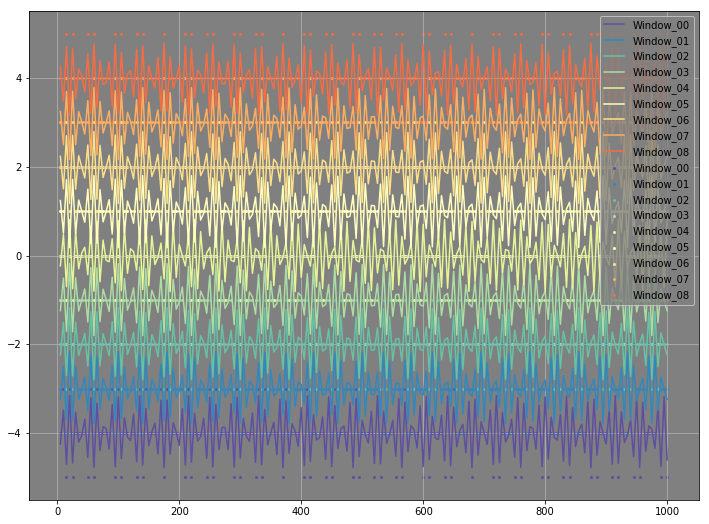

In [89]:
plt.figure(figsize=(12,9))
plt.rcParams['axes.facecolor']='grey'
nWindows=len(simDataTable.Window.unique())
for window in np.sort(simDataTable.Window.unique()):
    plotData=simDataTable[simDataTable.Window==window]
    plt.scatter(plotData.Time,
                (plotData.X_Index-(nWindows-1)/2.)*windowWidth,
                c=Spectral11[window],
                s=4,
                label='Window_%02g'%window)
    plt.plot(plotData.Time,
             plotData.X,Spectral11[window],
             label='Window_%02g'%window)
plt.legend()
plt.grid()
plt.show()

--- --- ---
escapeMatrix entry for window 0:
[0.110, 0.000, 0.150, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 0.733
--- --- ---
escapeMatrix entry for window 1:
[0.000, 0.109, 0.000, 0.139, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 0.786
--- --- ---
escapeMatrix entry for window 2:
[0.000, 0.000, 0.119, 0.000, 0.129, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 0.923
--- --- ---
escapeMatrix entry for window 3:
[0.000, 0.000, 0.000, 0.119, 0.000, 0.129, 0.000, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 0.923
--- --- ---
escapeMatrix entry for window 4:
[0.000, 0.000, 0.000, 0.000, 0.147, 0.000, 0.098, 0.000, 0.000, 0.000, 0.000]
Ratio of left to right exit frequencies: 1.500
--- --- ---
escapeMatrix entry for window 5:
[0.000, 0.000, 0.000, 0.000, 0.000, 0.129, 0.000, 0.119, 0.000, 0.000, 0.000]
Ratio of left to right exit

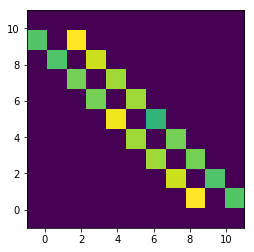

In [91]:
#note that our window indexing starts at 0
#this causes a problem for boolean operations since 0 evaluates to false
#while non-zero evaluates as true.
#moreover, our 'bins' span from -1 to nWindows+1...
#thus we will temporarily add 2 to all window and X_index values
#this way our X_index will span values from 1 to nWindows+2
windows=np.sort(simDataTable.Window.unique())
xbins=np.sort(simDataTable.X_Index.unique())
nBins=len(xbins)
escapeMat=np.zeros((nBins,nBins))
escapeRatios=np.zeros(len(windows))
#iVal->escape matrix row index
#xbin->window
#cVal->place holder for bin index with indexing starting at 1
for iVal,xbin in enumerate(xbins):
    if xbin in windows:
        tempDat=simDataTable[simDataTable.Window==xbin]
        cVal=xbin+2
        binVec=np.array(tempDat.X_Index+2)
        binC=(binVec==cVal)
        binT=(1-binC[1:])*binC[:-1]*binVec[1:]
        tCounts=np.unique(binT,return_counts=True)
        transInds=tCounts[0][1:] #first entry should always be for binT==0
        transCounts=tCounts[1][1:]
        cCount=np.sum(binC)
        for iInd,Ind in enumerate(transInds):
            escapeMat[iVal,Ind-1]=1.*transCounts[iInd]/cCount
        escapeRatios[iVal-1]=escapeMat[iVal,iVal-1]/escapeMat[iVal,iVal+1]
        print "--- --- ---"
        print "escapeMatrix entry for window %g:"%xbin
        print '['+', '.join(map(lambda x: '%.3f'%x,escapeMat[iVal,:]))+']'
        print 'Ratio of left to right exit frequencies: %.3f'%(
            escapeRatios[iVal-1])
print "--- --- ---"

plt.imshow(escapeMat,extent=(-1,nBins,-1,nBins))
plt.show()

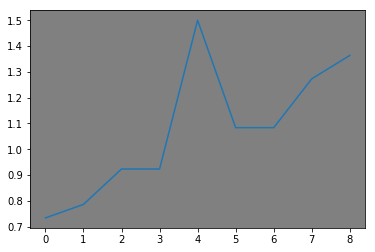

In [92]:
plt.plot(escapeRatios)